In [1]:
import numpy as np

# Шаг сетки и узлы по осям
h = 0.1
x = np.arange(0, 3 + h, h)   # от 0.0 до 3.0 с шагом 0.1
y = np.arange(0, 3 + h, h)
nx, ny = x.size, y.size
assert nx == 31 and ny == 31, f"Неправильный размер сетки: {nx}x{ny}, ожидалось 31x31."

# Двумерные массивы координат (X[i,j] = x[j], Y[i,j] = y[i])
X, Y = np.meshgrid(x, y)

# Булева маска области L-образной формы: (x <= 1) OR (y <= 1)
domain_mask = (X <= 1.0) | (Y <= 1.0)

# Проверяем крайние случаи (углы прямоугольника [0,3]^2):
# (0,0) внутри, (3,0) внутри, (0,3) внутри, (3,3) вне области
assert domain_mask[0,0] == True    # (x=0,y=0)
assert domain_mask[0,-1] == True   # (x=3,y=0)
assert domain_mask[-1,0] == True   # (x=0,y=3)
assert domain_mask[-1,-1] == False # (x=3,y=3)

print(f"Сетка: {nx}x{ny} узлов. Узлов в области (включая границу): {np.count_nonzero(domain_mask)}.")


Сетка: 31x31 узлов. Узлов в области (включая границу): 561.


In [2]:
import math

# Инициализируем массив решения u (включая boundary, остальное пока 0)
u = np.zeros_like(X)

# 1) Граница Γ2: x=3, 0<=y<=1 -> u = y - d
d = 1.0
j3 = np.argmin(np.abs(x - 3.0))  # индекс, где x=3
for i in range(ny):
    if Y[i, j3] <= 1.0 + 1e-9:  # y <= 1
        u[i, j3] = Y[i, j3] - d

# 2) Граница Γ3: y=1, 1<=x<=3 -> u = (x-c)*(x-a)
c, a = 1.0, 3.0
i1 = np.argmin(np.abs(y - 1.0))  # индекс, где y=1
for j in range(nx):
    if X[i1, j] >= c - 1e-9:  # x >= 1
        u[i1, j] = (X[i1, j] - c) * (X[i1, j] - a)

# 3) Γ4: x=1, 1<=y<=3 -> u = sin(pi*x) = 0 (при x=1)
j1 = np.argmin(np.abs(x - 1.0))  # индекс x=1
for i in range(ny):
    if Y[i, j1] >= 1.0 - 1e-9:  # y >= 1
        u[i, j1] = math.sin(math.pi * X[i, j1])  # = 0

# 4) Γ5: y=3, 0<=x<=1 -> u = sin(pi*y) = 0
i3 = np.argmin(np.abs(y - 3.0))  # индекс y=3
for j in range(nx):
    if X[i3, j] <= 1.0 + 1e-9:
        u[i3, j] = math.sin(math.pi * Y[i3, j])  # = 0

# 5) Γ6: x=0, 0<=y<=3 -> u = sin(pi*y)
j0 = np.argmin(np.abs(x - 0.0))  # индекс x=0
for i in range(ny):
    u[i, j0] = math.sin(math.pi * Y[i, j0])

# 6) Γ1: y=0, 0<=x<=3 -> u = sin(pi*x) (выполняем последним, чтобы (3,0)=0)
i0 = np.argmin(np.abs(y - 0.0))  # индекс y=0
for j in range(nx):
    u[i0, j] = math.sin(math.pi * X[i0, j])

# Проверяем несколько граничных точек:
assert np.isclose(u[i0, 0], 0.0)      # (0,0) -> sin(0)=0
assert np.isclose(u[i0, nx-1], 0.0)   # (3,0) -> должно стать 0 после Γ1
assert np.isclose(u[i3, 0], 0.0)      # (0,3) -> sin(pi*3)=0
assert np.isclose(u[i1, j3], 0.0)     # (3,1) -> (x-1)(x-3) при x=3 -> 0
print("Граничные условия установлены (выборочные проверки пройдены).")


Граничные условия установлены (выборочные проверки пройдены).


In [3]:
import time

def solve_sor(u_initial, f, mask, omega, eps=1e-4, max_iter=10000):
    """
    Выполняет итерации SOR для уравнения Laplace u = f на маске mask,
    возвращает (iterations, converged, u_result).
    """
    u = u_initial.copy().astype(float)
    ny, nx = u.shape
    for it in range(1, max_iter+1):
        diff_max = 0.0
        # Проходим по всем узлам внутри области (не по границе)
        for i in range(1, ny-1):
            for j in range(1, nx-1):
                if not mask[i, j]:
                    continue  # пропускаем точки вне области
                # Пропускаем граничные узлы (они уже заданы), оставляем только внутренние
                # В данной маске граничные сегменты маски тоже True, так что нам надо отличать:
                # Решение: будем просто не обновлять те узлы, где мы только что установили ГУ.
                # Можно проверять положение, например: 
                #   (j==j3 and Y[i,j]<=1) или др., но проще - если координаты по маске в ГУ:
                # Но здесь мы знаем условия: граничные узлы имеют X==0, X==3, Y==0, Y==3,
                #    или (X==1,Y>=1), (Y==1,X>=1). Мы сделаем простую проверку:
                if (i == 0 or i == ny-1 or j == 0 or j == nx-1):
                    continue  # граничные ребра прямоугольника
                # Дополнительно: внутренние ребра L-образной формы:
                if X[i,j] == 1.0 and Y[i,j] >= 1.0:
                    continue
                if Y[i,j] == 1.0 and X[i,j] >= 1.0:
                    continue

                # Начальное значение в этой итерации (предыдущее)
                old_val = u[i,j]
                # Соседи (все четыре стороны; граничные соседи уже в u от граничных условий)
                u_up = u[i+1, j]
                u_dn = u[i-1, j]
                u_rt = u[i, j+1]
                u_lt = u[i, j-1]
                # Итерационная формула SOR:
                new_val = (1 - omega)*old_val + (omega/4.0) * (u_up + u_dn + u_rt + u_lt - h*h * f[i,j])
                u[i,j] = new_val
                diff = abs(new_val - old_val)
                if diff > diff_max:
                    diff_max = diff

        if diff_max < eps:
            return it, True, u
    return max_iter, False, u

# Задаём массив правой части и точное решение для сравнения
f = (1 - X**2) * (1 - Y**2)
u_exact = (1 - X**2) * (1 - Y**2)

# Оценка оптимального ω по формуле:
omega_est = 2.0/(1.0 + np.sin(np.pi*h))
print(f"Приближённая оценка оптимального ω ≈ {omega_est:.3f}")

# Тестируем несколько значений ω для скорости сходимости
for omega in [1.0, 1.2, 1.4, omega_est, 1.6, 1.8]:
    start = time.time()
    iters, conv, _ = solve_sor(u, f, domain_mask, omega, eps=1e-4)
    t = time.time() - start
    status = "OK" if conv else "не сошлось"
    print(f"ω = {omega:.2f}: итераций = {iters}, статус = {status}, время = {t:.3f} с")


Приближённая оценка оптимального ω ≈ 1.528
ω = 1.00: итераций = 92, статус = OK, время = 0.108 с
ω = 1.20: итераций = 68, статус = OK, время = 0.076 с
ω = 1.40: итераций = 49, статус = OK, время = 0.049 с
ω = 1.53: итераций = 39, статус = OK, время = 0.049 с
ω = 1.60: итераций = 32, статус = OK, время = 0.050 с
ω = 1.80: итераций = 51, статус = OK, время = 0.051 с


In [4]:
# Выбираем оптимальный omega (например, близкий к оценке)
omega_opt = omega_est  # можно подобрать вручную после просмотра результатов перебора

# Решаем методом SOR до сходимости
iters, converged, u_num = solve_sor(u, f, domain_mask, omega_opt, eps=1e-4)
if converged:
    print(f"SOR сошёлся за {iters} итераций при ω = {omega_opt:.3f}.")
else:
    print(f"SOR не сошёлся за {iters} итераций при ω = {omega_opt:.3f}.")


SOR сошёлся за 39 итераций при ω = 1.528.


Максимальная абсолютная ошибка в узлах: 8.000e+00


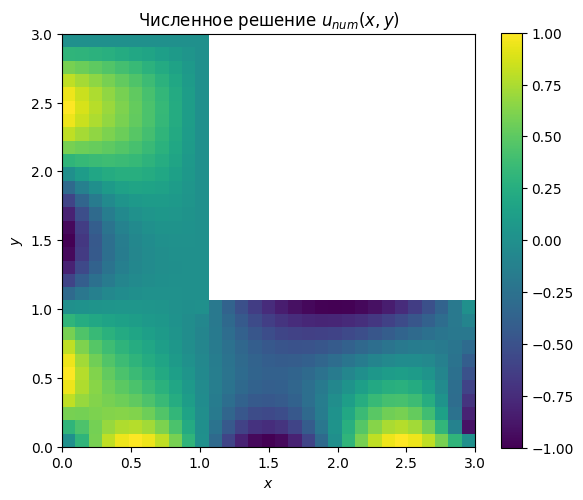

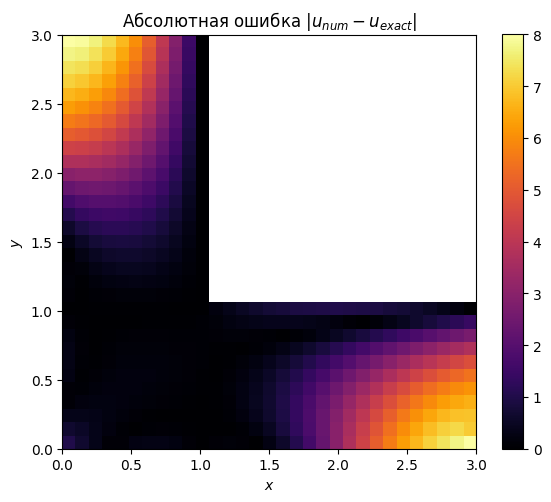

In [5]:
import matplotlib.pyplot as plt

# Абсолютная погрешность внутри области
error = np.abs(u_num - u_exact)
error_masked = np.where(domain_mask, error, np.nan)

# График численного решения
plt.figure(figsize=(6,5))
c1 = plt.imshow(np.where(domain_mask, u_num, np.nan), origin='lower', extent=(0,3,0,3), cmap='viridis')
plt.colorbar(c1)
plt.title('Численное решение $u_{num}(x,y)$')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.tight_layout()

# График абсолютной ошибки
plt.figure(figsize=(6,5))
c2 = plt.imshow(error_masked, origin='lower', extent=(0,3,0,3), cmap='inferno')
plt.colorbar(c2)
plt.title('Абсолютная ошибка $|u_{num} - u_{exact}|$')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.tight_layout()

# Вывод максимальной ошибки
max_error = np.nanmax(error_masked)
print(f"Максимальная абсолютная ошибка в узлах: {max_error:.3e}")
